# Stakeholder Mapping - 04

Using outputs dir: /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state
✅ Wrote mapping CSV: /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state/pea_stakeholder_scores_mapping.csv

Preview (first 10 rows):
             stakeholder_type                                                              entity  abbr  category                                                                                                                                                                                                                                                justification                                                                         source_ref power interest threat collab  delete                                                  notes  confidence
                   Government                                Kaduna State M

stakeholder_type  \
0                      Government   
1                      Government   
2                 Natural persons   
3     Civil Society Organisations   
4                  Private Sector   
5   Community-Based Organisations   
6   Donors/International Partners   
7                           Media   
8                      Government   
9     Civil Society Organisations   
10                Natural persons   
11                 Private Sector   
12  Community-Based Organisations   
13  Donors/International Partners   
14                          Media   
15                     Government   
16    Civil Society Organisations   
17                Natural persons   
18                 Private Sector   
19  Community-Based Organisations   
20  Donors/International Partners   
21                          Media   
22                     Government   
23    Civil Society Organisations   
24                Natural persons   
25                 Private Sector   
26  Community-Based Organisations   
27  Donors/International Partners   
28                          Media   
29                     Government   
30    Civil Society Organisations   
31                Natural persons   
32                 Private Sector   
33  Community-Based Organisations   
34  Donors/International Partners   
35                          Media   
36                     Government   
37    Civil Society Organisations   
38                Natural persons   

                                               entity        abbr    category  \
0                Kaduna State Ministry of Environment         KSM        Core   
1                      Kaduna State House of Assembly         KSH        Core   
2   Samuel Aruwan (Commissioner for Internal Secur...          SA        Core   
3                             Green Kaduna Initiative         GKI        Core   
4              Kaduna State Forestry Products Company         KSF        Core   
5               Kaduna Community Forestry Association         KCF        Core   
6                   World Wildlife Fund (WWF) Nigeria         WWF   Secondary   
7                      Kaduna State Media Corporation       KSM#2   Secondary   
8                    Kaduna State Forestry Commission       KSF#2        Core   
9   Environmental Rights Action/Friends of the Ear...         ERA   Secondary   
10           Aisha D. Mohammed (Director of Forestry)         ADM        Core   
11                              Kaduna Timber Company         KTC  Peripheral   
12                           Kaduna Women in Forestry         KWI  Peripheral   
13  United Nations Development Programme (UNDP) Ni...         UND   Secondary   
14                               The Kaduna Chronicle         TKC   Secondary   
15        Kaduna State Planning and Budget Commission         KSP        Core   
16                   Nigerian Conservation Foundation         NCF   Secondary   
17  Musa Ibrahim (Chairman, Kaduna State Forestry ...          MI        Core   
18                           Kaduna Agroforestry Ltd.         KAL  Peripheral   
19              Kaduna Youth for Sustainable Forestry         KYF  Peripheral   
20                  Global Environment Facility (GEF)         GEF   Secondary   
21                               The Guardian Nigeria         TGN   Secondary   
22               Kaduna State Ministry of Agriculture       KSM#3        Core   
23                       Friends of the Earth Nigeria         FOT   Secondary   
24   Fatima Aliyu (Director of Environmental Affairs)          FA        Core   
25                        Kaduna Forest Products Ltd.         KFP  Peripheral   
26               Kaduna Environmental Awareness Group         KEA  Peripheral   
27                    African Development Bank (AfDB)         ADB   Secondary   
28                                  ThisDay Newspaper  ThisDay Ne   Secondary   
29  Kaduna State Environmental Protection Agency (...         KSE        Core   
30                       

✅ Plots saved:
 - /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state/map_power_interest.png 
 - /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state/map_threat_collab.png


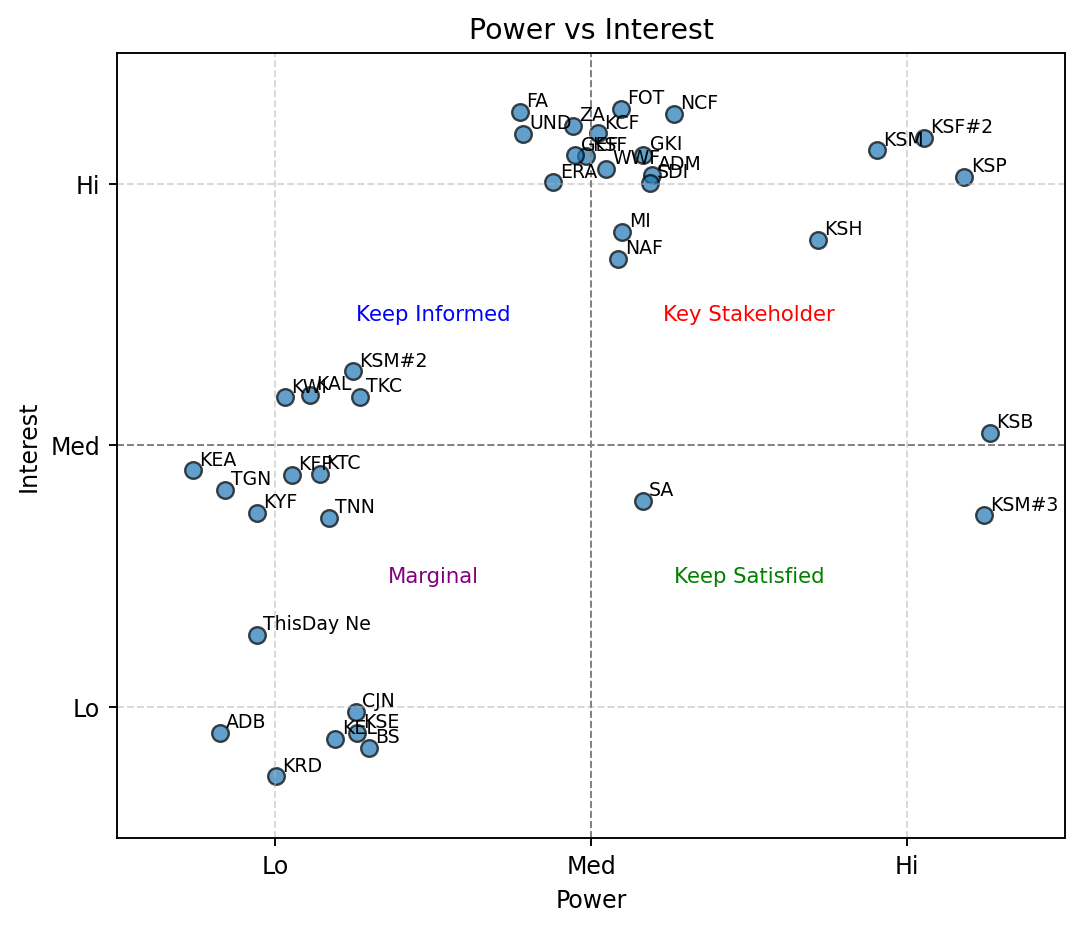

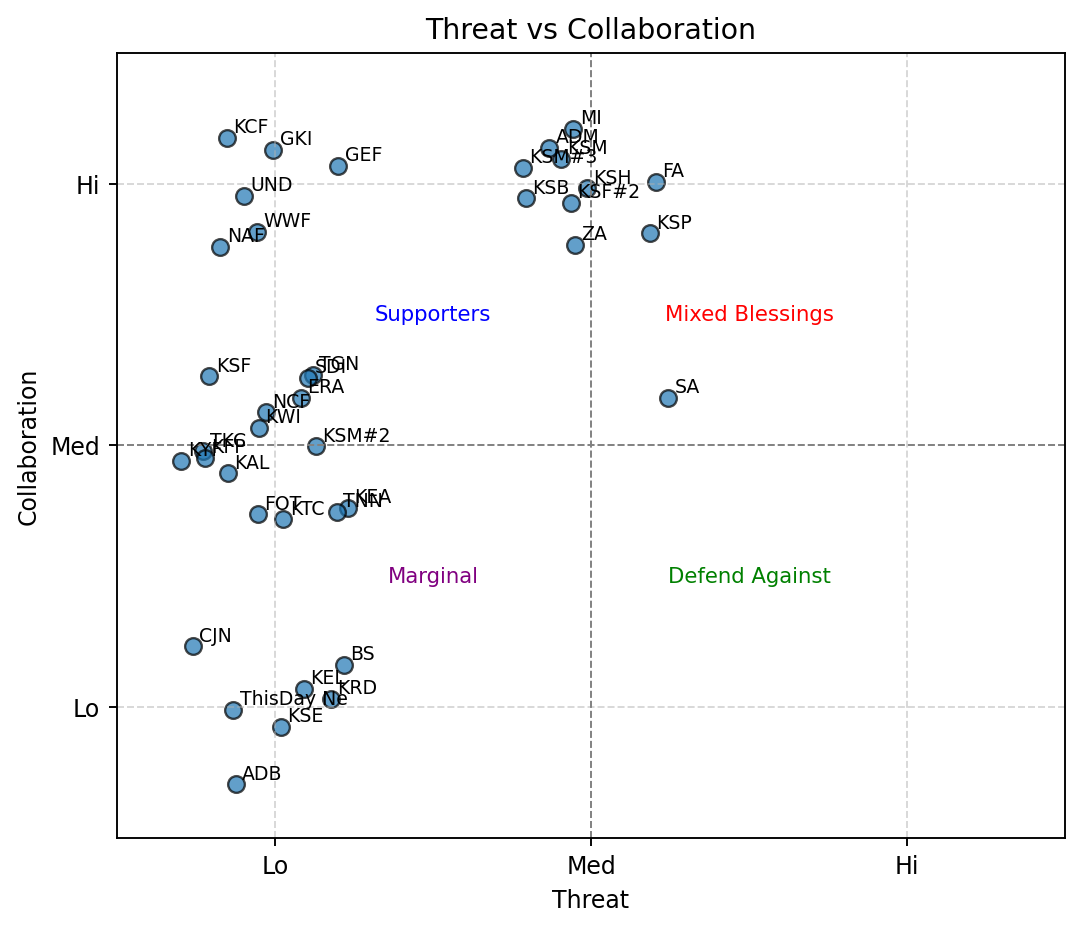

In [7]:
# === Generate/refresh pea_stakeholder_scores_mapping.csv for the CURRENT state ===
# Reads current_state from configs/run.yaml, finds the right outputs/<state[-state]> folder,
# loads pea_stakeholder_scores.csv, ensures 'abbr' (after 'entity'), and writes
# pea_stakeholder_scores_mapping.csv (overwrite).

import re
import json
from pathlib import Path
from datetime import datetime
import pandas as pd

# ---------- helpers ----------
def find_project_root(max_up=8):
    p = Path.cwd()
    for _ in range(max_up):
        if (p / "configs").exists() and ((p / "src").exists() or (p / "notebooks").exists()):
            return p
        p = p.parent
    return Path.cwd()

def slugify(s: str) -> str:
    return re.sub(r"[^0-9a-zA-Z]+","-", (s or "").strip().lower()).strip("-") or "unknown"

def make_abbr(name: str) -> str:
    if not isinstance(name, str) or not name.strip():
        return ""
    w = re.split(r"\s+", name.strip())
    if len(w) >= 3:
        ab = "".join(x[0].upper() for x in w[:3])
    else:
        ab = name[:10]
    return ab.rstrip("(")

def dedupe_labels(series: pd.Series) -> pd.Series:
    seen, out = {}, []
    for s in series.astype(str):
        key = s or ""
        if key not in seen:
            seen[key] = 1
            out.append(key)
        else:
            seen[key] += 1
            out.append(f"{key}#{seen[key]}")
    return pd.Series(out, index=series.index)

# ---------- resolve project + state ----------
ROOT = find_project_root()
run_yaml = ROOT / "configs" / "run.yaml"
if not run_yaml.exists():
    raise FileNotFoundError(f"Missing configs/run.yaml at {run_yaml}. Please create it with current_state/current_issue.")

import yaml
cfg = yaml.safe_load(run_yaml.read_text(encoding="utf-8")) or {}
STATE = (cfg.get("current_state") or "").strip()
if not STATE:
    raise ValueError("configs/run.yaml has no 'current_state'. Add it, e.g. current_state: 'Kano State'")

STATE_SLUG = slugify(STATE)

# Prefer <slug>-state if it exists; else <slug>; else create <slug>-state
cand1 = ROOT / "outputs" / f"{STATE_SLUG}-state"
cand2 = ROOT / "outputs" / STATE_SLUG
if cand1.exists():
    OUT_DIR = cand1
elif cand2.exists():
    OUT_DIR = cand2
else:
    OUT_DIR = cand1
    OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using outputs dir: {OUT_DIR}")

# ---------- load scores ----------
src_scores = OUT_DIR / "pea_stakeholder_scores.csv"
if not src_scores.exists():
    raise FileNotFoundError(
        f"Scores file not found:\n{src_scores}\n"
        f"(State resolved to '{STATE}'. If this is wrong, update configs/run.yaml.)"
    )

df = pd.read_csv(src_scores)

# sanity: required columns
required_cols = ["entity","power","interest","threat","collab"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in {src_scores.name}: {missing}")

# ensure 'abbr' exists right after 'entity'
if "abbr" not in df.columns:
    abbrs = df["entity"].astype(str).map(make_abbr)
    df.insert(df.columns.get_loc("entity") + 1, "abbr", abbrs)
else:
    # move abbr to be right after entity
    cols = list(df.columns)
    if cols.index("abbr") != cols.index("entity") + 1:
        cols.remove("abbr")
        epos = cols.index("entity")
        cols = cols[:epos+1] + ["abbr"] + cols[epos+1:]
        df = df[cols]
    # clean + de-duplicate
    df["abbr"] = df["abbr"].astype(str).str.rstrip("(")

df["abbr"] = dedupe_labels(df["abbr"])

# ---------- write mapping ----------
dst_map = OUT_DIR / "pea_stakeholder_scores_mapping.csv"
df.to_csv(dst_map, index=False)
print("✅ Wrote mapping CSV:", dst_map)

# Optional: show quick preview
print("\nPreview (first 10 rows):")
print(df.head(10).to_string(index=False))

# ----------------- Show the dataframe -----------------
try:
    from IPython.display import display
    display(df)
except Exception:
    print("\nPreview of mapping dataframe:\n", df.head(20).to_string(index=False))
# # ---------- preload data ----------
try:
    FULL_DF = load_scores_df(OUT_DIR)
    STATUS_INIT = f"✅ Loaded {len(FULL_DF)} rows from: {OUT_DIR/'pea_stakeholder_scores.csv'}"
except Exception as e:
    FULL_DF = pd.DataFrame()
    STATUS_INIT = f"⚠️ Load failed: {e}"

# ---------- plotting helpers ----------
MAP = {"Lo": 1, "Med": 2, "Hi": 3}
def _to_num(s: pd.Series) -> pd.Series:
    return s.map(MAP).astype(float)

def _scatter_with_labels(ax, x, y, labels, jitter=0.30):
    xs = x + np.random.uniform(-jitter, jitter, size=len(x))
    ys = y + np.random.uniform(-jitter, jitter, size=len(y))
    ax.scatter(xs, ys, s=50, alpha=0.7, edgecolors="k")
    for xi, yi, lab in zip(xs, ys, labels):
        if str(lab).strip():
            ax.text(xi + 0.02, yi + 0.02, str(lab), fontsize=8)

def _style_axes(ax, xlabel, ylabel, title, invert_x=False, quadrant_labels=None):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks([1,2,3], ["Lo","Med","Hi"])
    ax.set_yticks([1,2,3], ["Lo","Med","Hi"])
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.axhline(2, color="gray", linestyle="--", linewidth=0.8)
    ax.axvline(2, color="gray", linestyle="--", linewidth=0.8)
    if quadrant_labels:
        for (x, y, text, color) in quadrant_labels:
            ax.text(x, y, text, fontsize=9, ha="center", va="center", color=color)
    if invert_x:
        ax.invert_xaxis()
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0.5, 3.5)

def plot_power_interest(df_in: pd.DataFrame, out_dir: Path) -> Path:
    x = _to_num(df_in["power"]);   y = _to_num(df_in["interest"]); labels = df_in["abbr"]
    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    _scatter_with_labels(ax, x, y, labels, jitter=0.30)
    qlbls = [
        (1.5,1.5,"Marginal","purple"),
        (2.5,1.5,"Keep Satisfied","green"),
        (1.5,2.5,"Keep Informed","blue"),
        (2.5,2.5,"Key Stakeholder","red"),
    ]
    _style_axes(ax, "Power", "Interest", "Power vs Interest", invert_x=True, quadrant_labels=qlbls)
    out = out_dir / "map_power_interest.png"
    fig.savefig(out, dpi=170, bbox_inches="tight")
    plt.close(fig)
    return out

def plot_threat_collab(df_in: pd.DataFrame, out_dir: Path) -> Path:
    x = _to_num(df_in["threat"]);  y = _to_num(df_in["collab"]);   labels = df_in["abbr"]
    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    _scatter_with_labels(ax, x, y, labels, jitter=0.30)
    qlbls = [
        (1.5,1.5,"Marginal","purple"),
        (2.5,1.5,"Defend Against","green"),
        (1.5,2.5,"Supporters","blue"),
        (2.5,2.5,"Mixed Blessings","red"),
    ]
    _style_axes(ax, "Threat", "Collaboration", "Threat vs Collaboration", invert_x=True, quadrant_labels=qlbls)
    out = out_dir / "map_threat_collab.png"
    fig.savefig(out, dpi=170, bbox_inches="tight")
    plt.close(fig)
    return out

# ---------- build plots ----------
p1 = plot_power_interest(df, OUT_DIR)
p2 = plot_threat_collab(df, OUT_DIR)

print("✅ Plots saved:\n -", p1, "\n -", p2)

# ---------- show inline if in a notebook ----------
try:
    from IPython.display import display, Image
    display(Image(filename=str(p1)))
    display(Image(filename=str(p2)))
except Exception:
    pass